<a href="https://colab.research.google.com/github/intimanjunath/Clustering/blob/main/i_audio_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Install Required Dependencies
!pip install timm==0.6.7 ftfy regex einops fvcore decord==0.6.0
!pip install pytorchvideo scikit-learn matplotlib
!git clone https://github.com/facebookresearch/ImageBind.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=139a861e231120e9a3e2965e4a3f423a013f8051b7ddb20584311e164ff0182d
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=604ce957f6fc8b49262970f7c042e15e6af2d79d199f9c1f9b530daa8c697917
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b9

In [2]:
# If mayavi causes an issue, skip its installation:
%cd /content/ImageBind
!sed -i '/mayavi/d' requirements.txt
!pip install -r requirements.txt

/content/ImageBind
  Cloning https://github.com/facebookresearch/pytorchvideo.git (to revision 28fe037d212663c6a24f373b94cc5d478c8c1a1d) to /tmp/pip-install-6e79jgd2/pytorchvideo_3fd09ddac1b440269a48483a20de1b8a
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorchvideo.git /tmp/pip-install-6e79jgd2/pytorchvideo_3fd09ddac1b440269a48483a20de1b8a
  Running command git rev-parse -q --verify 'sha^28fe037d212663c6a24f373b94cc5d478c8c1a1d'
  Running command git fetch -q https://github.com/facebookresearch/pytorchvideo.git 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Running command git checkout -q 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Resolved https://github.com/facebookresearch/pytorchvideo.git to commit 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is 

In [3]:
# Step 2: Import Necessary Libraries
import os
import torch
import numpy as np
import wave
import struct
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
from imagebind import data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

In [4]:
# Step 3: Set Up the ImageBind Model
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Initialize ImageBind
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

print("ImageBind model ready!")

  0%|          | 0.00/4.47G [00:00<?, ?B/s]

ImageBind model ready!


In [5]:
# Step 4: Generate and Read Audio Files
def create_sine_wave(frequency, duration, sample_rate=44100, amplitude=1.0):
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    return amplitude * np.sin(2 * np.pi * frequency * t)

def generate_audio_file(filename, frequency, duration):
    audio_data = create_sine_wave(frequency, duration)
    scaled = np.int16(audio_data * 32767)
    with wave.open(filename, 'w') as wav_file:
        wav_file.setnchannels(1)
        wav_file.setsampwidth(2)
        wav_file.setframerate(44100)
        wav_file.writeframes(struct.pack('<' + 'h'*len(scaled), *scaled))

def read_audio_file(filename):
    with wave.open(filename, 'r') as wav_file:
        frames = wav_file.readframes(-1)
        return np.frombuffer(frames, dtype=np.int16)

# Generate synthetic audio files
os.makedirs("audio_files", exist_ok=True)
generate_audio_file('audio_files/audio1.wav', 440, 3)  # A4 note
generate_audio_file('audio_files/audio2.wav', 261.63, 3)  # C4 note
generate_audio_file('audio_files/audio3.wav', 329.63, 3)  # E4 note

audio_files = ['audio_files/audio1.wav', 'audio_files/audio2.wav', 'audio_files/audio3.wav']

print("Audio files generated!")

Audio files generated!


In [6]:
# Step 5: Extract Audio Embeddings Using ImageBind
# Preprocess audio files
audio_paths = [os.path.join(os.getcwd(), file) for file in audio_files]

inputs = {
    ModalityType.AUDIO: data.load_and_transform_audio_data(audio_paths, device),
}

# Generate embeddings
with torch.no_grad():
    embeddings = model(inputs)

# Extract audio embeddings
audio_embeddings = embeddings[ModalityType.AUDIO].cpu().numpy()
print("Audio embeddings shape:", audio_embeddings.shape)

Audio embeddings shape: (3, 1024)


In [7]:
# Step 6: Perform Clustering
# Reduce dimensions with PCA
pca = PCA(n_components=2)
audio_embeddings_pca = pca.fit_transform(audio_embeddings)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(audio_embeddings_pca)

print("Clustering complete!")
print("Cluster labels:", labels)

Clustering complete!
Cluster labels: [2 0 1]


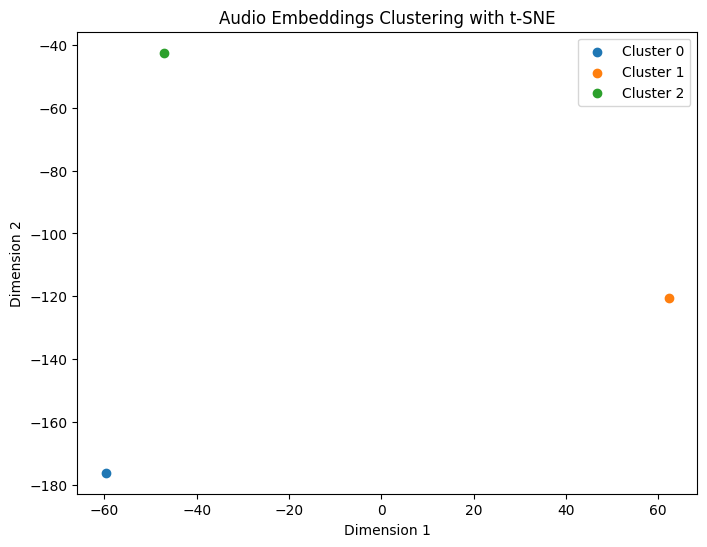

In [8]:
# Step 7: Visualize Clusters with t-SNE
tsne = TSNE(n_components=2, perplexity=2, random_state=42)
audio_tsne = tsne.fit_transform(audio_embeddings_pca)

plt.figure(figsize=(8, 6))
for cluster_id in set(labels):
    cluster_points = audio_tsne[labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
plt.legend()
plt.title("Audio Embeddings Clustering with t-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

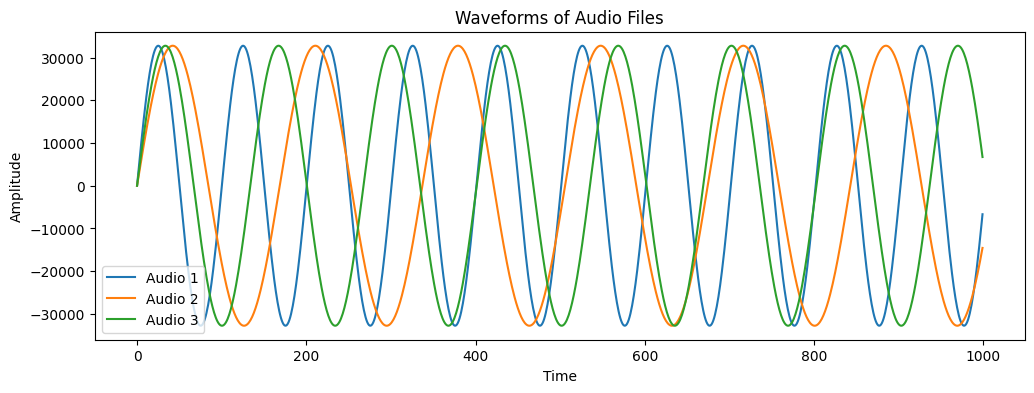

In [9]:
# Step 8: Visualize Audio Features
plt.figure(figsize=(12, 4))
for i, file in enumerate(audio_files):
    audio_data = read_audio_file(file)
    plt.plot(audio_data[:1000], label=f'Audio {i+1}')
plt.title("Waveforms of Audio Files")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()